## Project Reinforcement Learning

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [1]:
# %%capture
# !rm -r BatteryGrid
# !git clone https://github.com/MaxFeucht/BatteryGrid.git
# !pip install -e BatteryGrid

# import os
# os.chdir('BatteryGrid')
# !pip install -r requirements.txt
# !pip install -e gym-env


In [9]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
import random

from utils import RuleEvaluation, DDQNEvaluation, Plotter
from agent import DDQNAgent, TemporalDDQNAgent

from TestEnv import Electric_Car

seed = 2705
TRAIN = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) 
    return df_long.reset_index(drop=True)

train_name = 'data/train.xlsx'
val_name = 'data/validate.xlsx'

train = elongate(pd.read_excel(train_name))
val = elongate(pd.read_excel(val_name))

features_train = pd.read_csv('data/features_train.csv')
features_val = pd.read_csv('data/features_val.csv')

In [4]:
# # Feature Engineering
# from feature_eng import *

# gradient_sizes = [1, 2, 4, 6, 8, 12, 18, 24]
# fourier_window = 72
# window_sizes = [3, 6, 12, 24, 48, 72]

# features_train = features_pipeline(train, fourier_window, gradient_sizes, window_sizes)
# features_val = features_pipeline(val, fourier_window, gradient_sizes, window_sizes)

# features_train.fillna(0, inplace=True)
# features_val.fillna(0, inplace=True)

# features_train = features_train.replace([np.inf, -np.inf], 0)
# features_val = features_val.replace([np.inf, -np.inf], 0)

# features_train.to_csv('data/features_train.csv', index=False)
# features_val.to_csv('data/features_val.csv', index=False)


## RULE BASED AGENT

In [5]:
# # Evaluate Rule-Based Agent
# price_horizon = 24
# df = train_name

# rule_env = Electric_Car(path_to_test_data=df)
# eval_rule = RuleEvaluation(env = rule_env, price_horizon=price_horizon)
# eval_rule.evaluate(low_quantile = 0.25, high_quantile = 0.75, null_action = False)


In [6]:
# # Visualize Rule-Based Agent
# plot_range = (0, 100)

# plotter = Plotter(eval_rule, range = plot_range)
# plotter.plot_actions(battery = False, balance=False, absence = False)
# plotter.plot_actions(battery = False, balance=False, absence = True)
# plotter.plot_actions(battery = False, balance=True, absence = True)
# plotter.plot_actions(battery = True, balance=True, absence = True)

## DDQN AGENT

In [12]:
seed = 2705
rep = 1000000
batch_size = 32
gamma = 0.9
epsilon = 1.0
epsilon_decay = 29999
epsilon_min = 0.1
learning_rate = 1e-4
price_horizon = 96
future_horizon = 0
hidden_dim = 96
action_classes = 5
reward_shaping = True
factor = 1
verbose = False
TRAIN = True
df = train_name

In [8]:
if TRAIN:

    # Initialize Environment
    env = Electric_Car(path_to_test_data=df)


    #Initialize DQN
    agent = DDQNAgent(env = env,
                      features = features_train,
                      epsilon_decay = epsilon_decay,
                      epsilon_start = epsilon,
                      epsilon_end = epsilon_min,
                      discount_rate = gamma,
                      lr = learning_rate,
                      buffer_size = 100000,
                      price_horizon = price_horizon,
                      hidden_dim=hidden_dim,
                      action_classes = action_classes, 
                      verbose = verbose)

    obs, r, terminated, _, _ = env.step(random.randint(-1,1)) # Reset environment and get initial observation
    state, grads = agent.obs_to_state(obs)

    
    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    with tqdm(total=rep) as pbar:
        for i in range(rep):

            action = agent.choose_action(i, state, greedy = False) # Choose action (discrete)
            cont_action = agent.action_to_cont(action) # Convert to continuous action
            
            new_obs, r, t, _, _ = env.step(cont_action)
            new_state, new_grads = agent.obs_to_state(new_obs)
            
            # Reward Shapi            
            new_reward = agent.shape_reward(r, cont_action, grads, apply = reward_shaping, factor = factor)

            # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
            if state.shape[0] == agent.state_dim and new_state.shape[0] == agent.state_dim:
                agent.replay_memory.add_data((state, action, new_reward, t, new_state))

            #Update DQN
            loss = agent.optimize(batch_size)
            
            # Update values
            episode_balance += r
            episode_reward += r
            episode_loss += loss

            # New observation
            state = new_state
            grads = new_grads # Gradients for reward shaping
            
            pbar.update(1)

            if t:
                # Reset Environment
                env.counter = 0
                env.hour = 1
                env.day = 1
                episode_counter += 1
                print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
                episode_loss = 0
                episode_balance = 0
                episode_reward = 0
                
                
                if episode_counter % 4 == 0:
                    # Evaluate DQN
                    train_dqn = DDQNEvaluation(price_horizon = price_horizon)
                    train_dqn.evaluate(agent = agent)
                    
                    # Reset Environment
                    env.counter = 0
                    env.hour = 1
                    env.day = 1
                    

    # Save agent
    torch.save(agent.dqn_predict.state_dict(), f'models/agent_{action_classes}_hdim{hidden_dim}.pt')
    pbar.close

Number of engineered features:  49
State dimension:  147


/Users/maxfeucht/Documents/VU/Project Reinforcement Learning/BatteryGrid/agent.py:79: RuntimeWarning: invalid value encountered in divide
  return (var - np.min(var)) / (np.max(var) - np.min(var))
  0%|          | 2/1000000 [00:00<17:28:08, 15.90it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
  0%|          | 2496/1000000 [00:13<1:31:49, 181.06it/s]


KeyboardInterrupt: 

In [8]:
torch.save(agent.dqn_predict.state_dict(), f'models/agent_{action_classes}_hdim{hidden_dim}_newenv.pt')

In [13]:

# Initialize Environment
env = Electric_Car(path_to_test_data=df)

#Initialize DQN
agent = DDQNAgent(env = env,
                    features = features_train,
                    epsilon_decay = epsilon_decay,
                    epsilon_start = epsilon,
                    epsilon_end = epsilon_min,
                    discount_rate = gamma,
                    lr = learning_rate,
                    buffer_size = 100000,
                    price_horizon = price_horizon,
                    hidden_dim=hidden_dim,
                    action_classes = action_classes)

agent.dqn_predict.load_state_dict(torch.load(f'models/agent_{action_classes}_hdim{hidden_dim}.pt'))


TypeError: DDQNAgent.__init__() missing 4 required positional arguments: 'num_layers', 'positions', 'reward_shaping', and 'shaping_factor'

In [10]:
# Evaluate Rule-Based Agent
df = train_name

eval_ddqn = DDQNEvaluation(price_horizon=price_horizon)
eval_ddqn.evaluate(agent = agent)


Absolute Balance:  -4258.088978919754


In [ ]:
#Visualize DDQN Agent
plot_range = [2200, 2400]

plotter = Plotter(eval_ddqn, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [ ]:
# FIX DATE RANGE FOR DDQN EVALUATION!!

To Do Reward Shaping:

Think about rules to check which rewards to penalize / increase

Gradient-based Penalty Rules ####
    
- If gradient high and previous gradient high: Penalize selling
- If gradient high and previous gradient low:


Visualize, to which datapoints the rules will apply
Implement rules in the reward shaping function

In [13]:
penalized_reward

15428     4.55
15429    12.69
15430     4.30
15431     4.99
15432     1.50
         ...  
15923     1.40
15924     2.66
15925     3.15
15926     2.15
15927     6.36
Length: 500, dtype: float64

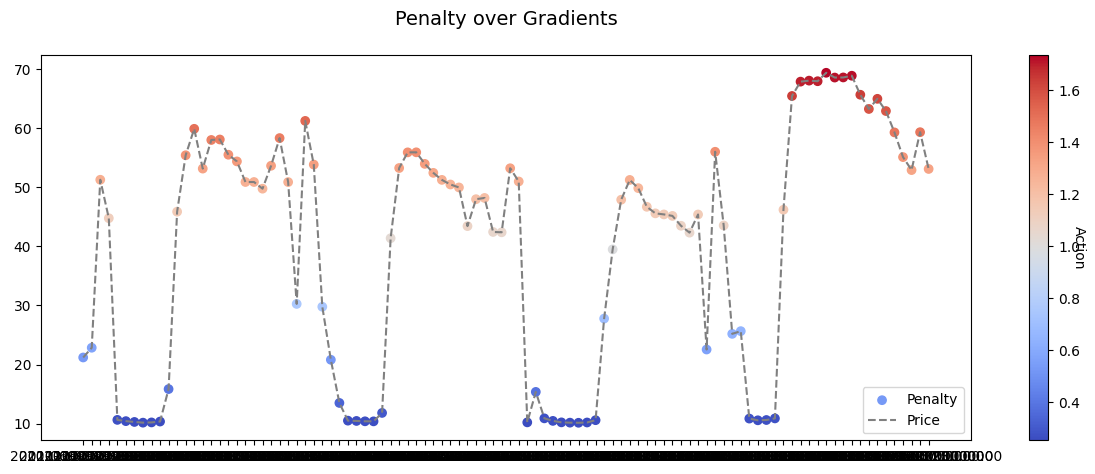

In [45]:

def penalty_func(reward, grad1, grad2, grad3, grad4, grad6, grad8, grad12, grad18, grad24):
    
    # Penalty for selling while price just started rising (recency is indicated by grad6 > grad3)
    if grad1 > 0:
        if grad6 < grad3:
            penalty = max(grad1, grad2) # the higher the gradient, the higher the penalty
        else:
            penalty = max(grad1, grad2) # the higher the gradient, the higher the penalty
    
    # Penalty for selling while price is falling
    #elif grad1 < 0:
    #    penalty = np.abs(grad2) # the higher the gradient to the second to last point, the higher the penalty
    
    # No penalty 
    else:
        penalty = 1 
    
    return np.abs(penalty)
    
    
def penalty_func(reward, valley, peak, grad1, grad2, grad4, grad6, grad8, grad12, grad18):


    penalty = abs(max(grad1, grad2, grad4, grad6, grad8, grad12, key = abs))
    penalty = reward
    #penalty = max(grad1, grad2, grad4, grad6, grad8, grad12, grad18)
    # if grad1 > 0 and grad2 > 0 and grad4 > 0 and grad6 > 0 and grad8 > 0 and grad12 > -reward/10 and grad18 > 0: #(grad6/grad4 > reward/(5*grad2)):
    #     penalty = 0
    
    # if valley == 1:
    #     penalty = 0
    
    # if peak == 1:
    #     penalty = 0
    
    return penalty * 1e-3 * 25
    


range = [12500-72, 12600-72]
df = features_val
plt.figure(figsize=(15,5))        
dates = df.iloc[range[0]:range[1],0]
current_price = df['price'].iloc[range[0]:range[1]]
penalized_reward = df[['price','month_non_business_valley', 'month_non_business_peak', 'gradient_1', 'gradient_2', 'gradient_6','gradient_4','gradient_8','gradient_12', 'gradient_18']].apply(lambda x: penalty_func(x.price, x.month_non_business_valley, x.month_non_business_peak, x.gradient_1, x.gradient_2,x.gradient_4, x.gradient_6, x.gradient_8, x.gradient_12, x.gradient_18), axis=1).iloc[range[0]:range[1]]
#penalized_reward = df[['price', 'hour', 'month_non_business_valley', 'month_non_business_peak']].apply(lambda x: penalty_func(x.price, x.hour, x.month_non_business_valley, x.month_non_business_peak), axis=1).iloc[range[0]:range[1]]
scatter = plt.scatter(dates, current_price, c = penalized_reward, cmap = 'coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Action',rotation=270)
plt.plot(dates, current_price, linestyle = '--', color = 'grey')
var_names = ['Penalty', 'Price']
plt.legend(var_names, loc = 'lower right')
#plt.clim(-1,1) 
#plt.xticks(rotation=45)
plt.title("Penalty over Gradients" + '\n', size = 14)
plt.show()


In [17]:
def normalize_data(var, axis=None):
        """
        Helper function to normalize data between 0 and 1
        """
        
        eps = 1e-10  # small constant

        if axis is None:
            norm = (var - np.min(var)) / (np.max(var) - np.min(var) + eps)
            return norm if np.max(var) != np.min(var) else np.ones(var.shape) # If all values are the same, return an array of ones
    
        else:
            return (var - np.min(var, axis=axis)) / (np.max(var, axis=axis) - np.min(var, axis=axis) + eps)


In [20]:
i

(0, 0.4380606986063256)

In [23]:
penalty

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.1287208927099446,
 1.2486456269240713,
 1.1612837795691946,
 1.3790620404720364,
 1.4213124676587803,
 2.001595209926227,
 2.6659220412233693,
 3.1751323977430053,
 2.8085650479948607,
 2.147082277665744,
 1.3393296090449127,
 0.9712926680785231,
 0.8406037181508994,
 0.6340665589996302,
 0.5058054010150376,
 0.43509395962819025,
 0.5855475851843953,
 0.6739395657936849,
 0.6965634505182888,
 0.778205370096658,
 0.8428472381668394,
 0.936576174266111,
 0.9805070271523975,
 0.9794487904657209,
 0.9785776943677216,
 1.0257550041256287,
 0.9664767153041378,
 1.1108590611277893,
 0.9641002090922285,
 1.224021520105175,
 1.6205431053778785,
 2.3812083108716293,
 2.176783354138523,
 2.3331905393682932,
 2.143428230469966,
 1.2945667941696453,
 1.0249369902961423,
 0.835623417147176,
 0.7160638862029748,
 0.6273833599922588,
 0.7086658832487063,
 1.1173103191565503,
 1.2091847074498343,
 1.45984

In [39]:
len(penalty)

58

In [47]:
del range

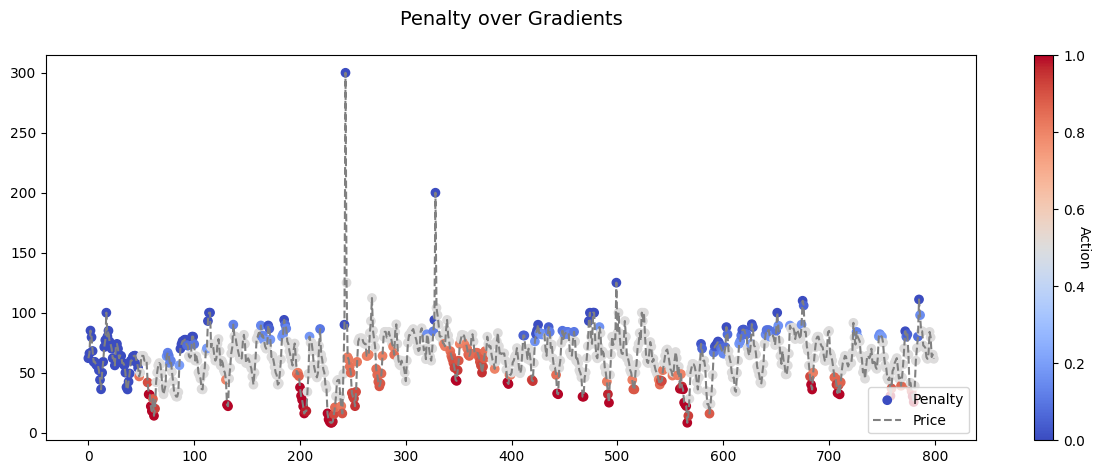

In [76]:
price_range = [10000, 10800]
window = 48

test_chunk = train.iloc[price_range[0]:price_range[1],:]
prices = test_chunk['price'].values
dates = test_chunk['datetime'].values

penalty = []
for i, price in enumerate(prices):
    
    if i < window:
        penalty.append(0)
    else:
        price_history = prices[i-window:i+1]
        norm_history = normalize_data(price_history)
        mean_price = np.mean(norm_history)
        #penalty.append(min(mean_price/norm_history[-1], 5))
        multiplier = 1-norm_history[-1]
        multiplier = multiplier if multiplier > 0.8 or multiplier < 0.2 else 0.5 # If the price is in the middle, the multiplier is 0

        penalty.append(multiplier)
        # if mean_price/norm_history[-1] > 10:
        #     print(i)
        #     print("Price", price)
        #     print("Price Window", prices[i-window:i+1])
        #     print("Normalized Price Window", norm_history)
        #     print("Averaged Mean Price", mean_price)
        #     print("Normalized Price", norm_history[-1])
        #     print("Normalized Mean / Price Ratio", mean_price/norm_history[-1])
        #     print('\n')
        

df = features_val
plt.figure(figsize=(15,5))     
xaxis = [i for i in range(len(prices))]   
#penalized_reward = df[['price', 'hour', 'month_non_business_valley', 'month_non_business_peak']].apply(lambda x: penalty_func(x.price, x.hour, x.month_non_business_valley, x.month_non_business_peak), axis=1).iloc[range[0]:range[1]]
scatter = plt.scatter(xaxis, prices, c = penalty, cmap = 'coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Action',rotation=270)
plt.plot(xaxis, prices, linestyle = '--', color = 'grey')
var_names = ['Penalty', 'Price']
plt.legend(var_names, loc = 'lower right')
#plt.clim(-1,1) 
#plt.xticks(rotation=45)
plt.title("Penalty over Gradients" + '\n', size = 14)
plt.show()

# INVESTIGATE

In [ ]:
import torch

price_horizon = 96
hidden_dim = 64

action = 0
cont_action = 0

for i in range(50):
    
    obs, reward, terminated, _, _ = agent.env.step(cont_action)
    
    old_action = action
    old_q_values = q_values

    print("Q-Values before update: ", round(old_q_values[old_action].detach().item(),3))
    print("Reward: ", reward)

    state, _ = agent.obs_to_state(obs)
    state  = torch.as_tensor(state, dtype = torch.float32)
    action = agent.choose_action(0, state, greedy = False)
    cont_action = agent.action_to_cont(action)
    q_values = agent.dqn_predict(torch.tensor(state))




# VALIDATION

In [ ]:
# Visualize DDQN Agent
price_horizon = 96
hidden_dim = 64
df = val_name

# Initialize Environment
env = Electric_Car(path_to_test_data=df)

#Initialize DQN
agent = DDQNAgent(env = env,
                    features = features_val,
                    epsilon_decay = epsilon_decay,
                    epsilon_start = epsilon,
                    epsilon_end = epsilon_min,
                    discount_rate = gamma,
                    lr = learning_rate,
                    buffer_size = 100000,
                    price_horizon = price_horizon,
                    hidden_dim=hidden_dim,
                    action_classes = action_classes)

agent.dqn_predict.load_state_dict(torch.load(f'models/agent_{action_classes}_hdim{hidden_dim}_newenv.pt'))


# Evaluate Rule-Based Agent
eval_ddqn = DDQNEvaluation(price_horizon=price_horizon)
eval_ddqn.evaluate(agent = agent)

#Visualize DDQN Agent
plot_range = [3000, 3600]

plotter = Plotter(eval_ddqn, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [ ]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = val

ddqn_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env_val.setup(df, price_horizon=price_horizon, action_classes = 3)
eval_ddqn_val = DDQNEvaluation(df, ddqn_env_val)
eval_ddqn_val.evaluate(agent = agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_ddqn_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

# TEMPORAL AGENT



In [8]:
epsilon = 1
epsilon_min = 0.05
epsilon_decay = 99999
gamma = 0.99
learning_rate = 5e-5
lin_hidden_dim = 32
temp_hidden_dim = 16
kernel_size = 3
dropout = 0.1
action_classes = 5
price_horizon = 120
future_horizon = 0
extra_penalty = False
verbose = False
TRAIN = True
rep = 2000000
batch_size = 32

In [9]:
if TRAIN:

    # Initialize Environment
    env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
    env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

    #Initialize DQN
    temporal_agent = TemporalDDQNAgent(env = env,
                            device = device,
                            epsilon_decay = epsilon_decay,
                            epsilon_start = epsilon,
                            epsilon_end = epsilon_min,
                            discount_rate = gamma,
                            lr = learning_rate,
                            buffer_size = 100000,
                            price_horizon = price_horizon,
                            lin_hidden_dim = lin_hidden_dim,
                            temp_hidden_dim = temp_hidden_dim,
                            kernel_size = kernel_size,
                            dropout = dropout,
                            action_classes = action_classes)

    obs, info = env.reset() # Reset environment and get initial observation

    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    with tqdm(total=rep) as pbar:
        for i in range(rep):

            action = temporal_agent.choose_action(i, obs['tensor'], greedy = False)
            new_obs,r,t,info = env.step(action)

            # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
            temporal_agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))

            #Update DQN
            loss = temporal_agent.optimize(batch_size)

            # Update values
            episode_balance += info['balance']
            episode_reward += r
            episode_loss += loss

            # New observation
            obs = new_obs

            pbar.update(1)

            if i % 200000 == 0:
              torch.save(temporal_agent.dqn_predict.state_dict(), f'models/temp_agent_{action_classes}_hdim{temp_hidden_dim}.pt')

            if t:
                obs, info = env.reset()
                episode_counter += 1
                print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
                episode_loss = 0
                episode_balance = 0
                episode_reward = 0

    # Save agent
    torch.save(temporal_agent.dqn_predict.state_dict(), f'models/temp_agent_{action_classes}_hdim{temp_hidden_dim}.pt')
    pbar.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Setup with price horizon:  120  and future horizon:  0  and action space:  5


  1%|▏         | 26203/2000000 [04:17<5:44:18, 95.55it/s]

Episode  1 Balance:  -7872.259392918585 Reward:  -7872.259392918585 Loss:  364551.5186349079


  3%|▎         | 52384/2000000 [08:51<5:14:27, 103.23it/s]

Episode  2 Balance:  -7391.0569275228045 Reward:  -7391.0569275228045 Loss:  740323.4686083794


  4%|▍         | 78566/2000000 [13:45<5:46:56, 92.31it/s]

Episode  3 Balance:  -5187.653382293564 Reward:  -5187.653382293564 Loss:  296431.74337768555


  5%|▌         | 104747/2000000 [18:53<7:42:31, 68.29it/s]

Episode  4 Balance:  -2164.047174287446 Reward:  -2164.047174287446 Loss:  61720.66595456004


  7%|▋         | 130937/2000000 [24:08<5:39:48, 91.67it/s]

Episode  5 Balance:  -1640.1887859755586 Reward:  -1640.1887859755586 Loss:  19395.118714027107


  8%|▊         | 157122/2000000 [29:24<5:36:32, 91.27it/s]

Episode  6 Balance:  -1591.9041785640034 Reward:  -1591.9041785640034 Loss:  7180.21764674969


  9%|▉         | 183299/2000000 [34:38<7:13:47, 69.80it/s]

Episode  7 Balance:  -1239.6413901954409 Reward:  -1239.6413901954409 Loss:  4170.589608972892


 10%|█         | 209483/2000000 [39:55<6:06:38, 81.39it/s]

Episode  8 Balance:  -1322.1944263822252 Reward:  -1322.1944263822252 Loss:  3672.9510052036494


 12%|█▏        | 235670/2000000 [45:13<5:56:13, 82.55it/s]

Episode  9 Balance:  -1246.4233044127761 Reward:  -1246.4233044127761 Loss:  2785.1822051750496


 12%|█▏        | 244883/2000000 [47:05<5:37:28, 86.68it/s]


KeyboardInterrupt: 

In [11]:
# Initialize Environment
env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

#Initialize DQN
temporal_agent = TemporalDDQNAgent(env = env,
                        device = device,
                        epsilon_decay = epsilon_decay,
                        epsilon_start = epsilon,
                        epsilon_end = epsilon_min,
                        discount_rate = gamma,
                        lr = learning_rate,
                        buffer_size = 100000,
                        price_horizon = price_horizon,
                        lin_hidden_dim = lin_hidden_dim,
                        temp_hidden_dim = temp_hidden_dim,
                        kernel_size = kernel_size,
                        dropout = dropout,
                        action_classes = action_classes)


temporal_agent.dqn_predict.load_state_dict(torch.load(f'models/temp_agent_{action_classes}_hdim{temp_hidden_dim}.pt'))

Setup with price horizon:  120  and future horizon:  0  and action space:  5


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

In [ ]:
## Training Evaluation of Temporal Agent:
price_horizon = 120
action_classes = 5
df = train

temp_env_train = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
temp_env_train.setup(df, price_horizon=price_horizon, action_classes = action_classes)
eval_temp_train = DDQNEvaluation(df, temp_env_train)
eval_temp_train.evaluate(agent = temporal_agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_temp_train, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [ ]:
## Validation of Temporal Agent:
price_horizon = 120
action_classes = 5
df = val

temp_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
temp_env_val.setup(df, price_horizon=price_horizon, action_classes = action_classes)
eval_temp_val = DDQNEvaluation(df, temp_env_val)
eval_temp_val.evaluate(agent = temporal_agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_temp_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

# Sanity Check of Environment

In [ ]:
action_classes = 11
test_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
test_env.setup(df, price_horizon=price_horizon, extra_penalty = True, action_classes = action_classes, verbose = True)
obs, info = test_env.reset()

for k in range(4):
    for i in reversed(range(action_classes)):
        test_env.step(i)


In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering:

# ⁠Gradient of curve
# Value of to same date last year if available
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


In [ ]:
start = 6500
range = 2000
plt.figure(figsize=(15,5))
plt.plot(train['datetime'][start:(start+range)], train['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

In [ ]:
start = 2000
range = 10000
plt.figure(figsize=(15,5))
plt.plot(val['datetime'][start:(start+range)], val['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

In [ ]:
price_horizon = 48
future_horizon = 0

env = gym.make('gym_env/BatteryGrid-v0')
env.setup(val, price_horizon=price_horizon, future_horizon=future_horizon, verbose=True)
obs,_ = env.reset()
print(obs)

obs,r,t,info = env.step(0)
obs,r,t,info = env.step(1)
obs,r,t,info = env.step(2)
obs,r,t,info = env.step(3)
obs,r,t,info = env.step(4)
obs,r,t,info = env.step(5)
obs,r,t,info = env.step(6)
obs,r,t,info = env.step(7)
obs,r,t,info = env.step(8)
obs,r,t,info = env.step(9)
obs,r,t,info = env.step(10)
obs,r,t,info = env.step(11)




{'battery': -0.5, 'prices': array([-0.76523653, -0.76929427, -0.85788829, -1.01614022, -1.07430118,
       -1.17642101, -1.38336583, -1.59031066, -1.08985586, -1.04183925,
       -0.96947619, -0.74089008, -0.43926462, -0.6421517 , -0.80716652,
       -0.96947619, -0.99449893, -0.38719027, -0.12276077,  0.37498886,
        0.18833275, -0.03957707,  0.60695643,  0.44261789, -0.10247207,
       -0.47781316, -0.36487269, -0.7949933 , -0.9687999 , -0.84706765,
       -0.59954541, -0.06865755,  0.29653919,  0.85244979,  1.17030622,
        1.36440153,  1.52062458,  1.12499477,  0.99649962,  0.70569481,
        0.86191786,  1.50980393,  2.16242404,  2.13266727,  1.41918104,
        1.00123365,  1.25010847,  1.11958445]), 'hour': -0.4583333333333333, 'day': -0.4904109589041096, 'presence': 1, 'tensor': array([-0.5       , -0.76523653, -0.76929427, -0.85788829, -1.01614022,
       -1.07430118, -1.17642101, -1.38336583, -1.59031066, -1.08985586,
       -1.04183925, -0.96947619, -0.74089008, -0.4

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  log

In [ ]:
action = 2
kWh = (6 - action) * 5 # Discretize, such that action 0 means most discharge, i.e., kWh = (5 - 0)* 5 = 25
kWh  -= 2.23 if action == 0 else 0 # Add charging loss

print(kWh)

20
